In [164]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import ast

In [165]:
path: str = './data/'
prokaryotes: pd.DataFrame = pd.read_csv(os.path.join(path, "prokaryotes_sec_structure.csv"))
prokaryotes = prokaryotes[prokaryotes['run_name'].str.contains('lysate', case=True)].dropna(subset=['meltPoint'])
secs = ['Helix1','Turn1','Sheet1','Helix2','Sheet2']
if isinstance(prokaryotes.iloc[0,28],str):
    for s in secs:
        prokaryotes[s] = prokaryotes[s].apply(lambda x: ast.literal_eval(x) if pd.isnull(x)==False else x)

Adding columns for total number of helices, sheets and coils

In [168]:
for s in secs:
    prokaryotes[f'{s}count'] = prokaryotes[s].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

Adding columns for relative Helix and Sheet abundance

In [169]:
a = np.array(prokaryotes['Length'])
for s in secs:
    prokaryotes[f'{s}perc'] = prokaryotes[s].apply(lambda x: pd.Series(x).map(len).sum() if isinstance(x, list) else np.nan)
    prokaryotes[f'{s}perc'] = np.array(prokaryotes[f'{s}perc'])/a

Adding columns for average Helix and Sheet length

In [170]:
for s in secs:
    prokaryotes[f'{s}avg'] = prokaryotes[s].apply(lambda x: np.array([len(lst) for lst in np.array(x,dtype=object)]).mean() if isinstance(x, list) and len(x)>0 else np.nan)

Adding column for relative fraction of secondary structures (Helix and Beta sheet combined)

In [171]:
prokaryotes['secstr1'] = np.array(prokaryotes['Helix1perc']) + np.array(prokaryotes['Sheet1perc'])
prokaryotes['secstr2'] = np.array(prokaryotes['Helix2perc']) + np.array(prokaryotes['Sheet2perc'])

In [172]:
aacids = ['A', 'V', 'I', 'L', 'M', 'F', 'W','N', 'Q', 'S', 'T', 'Y','D', 'E','R', 'H', 'K', 'C', 'P', 'G' ]
from function import rel_aa_comp
aagl = []
for n in aacids:
    for m in aacids:
        if n != m and [m,n] not in aagl:
            aagl.append([n,m])

In [173]:
for g in aagl:
    prokaryotes[f'{g[0]}{g[1]}'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x,[g[0],g[1]]))
    if abs(prokaryotes[f'{g[0]}{g[1]}'].corr(prokaryotes['meltPoint'])) < 0.2:  #Threshold for correlation
        prokaryotes = prokaryotes.drop(columns = [f'{g[0]}{g[1]}']).reset_index(drop=True)

Calculating amino acid percentage in (helices and sheets)

In [174]:
import itertools
test = [[1,2,3],[4,5,6],[7,8,9]]
tests = str(list(itertools.chain.from_iterable(test)))
print(type(tests))

<class 'str'>


In [175]:
prokaryotes['helixind'] = prokaryotes['Helix2'].apply(lambda x: list(np.concatenate(np.array(x,dtype=object))) if len(x) > 0 else [])
prokaryotes['helixseq'] = prokaryotes.apply(lambda row: [row['Sequence'][i] for i in row['helixind'] if i < len(row['Sequence'])], axis=1)
for a in aacids:
    prokaryotes[f'{a}helix'] = prokaryotes['helixseq'].apply(lambda x: x.count(a)/len(x) if len(x) > 0 else np.nan) 

In [176]:
def p_val(corr, n, alpha):
    import math
    import scipy.stats as stats
    if math.sqrt((1-(corr**2))/(n-2)) != 0 and n-2 != 0:
        t = (corr)/(math.sqrt((1-(corr**2))/(n-2)))
        p = 1 - stats.t.cdf(t, n-2)
        return [p, p < alpha]

In [177]:
for a in aacids:
    prokaryotes[str(a)] = prokaryotes['Sequence'].apply(lambda x: x.count(a)/len(x) if len(x) > 0 else np.nan)

In [180]:
aat = []
for a in aacids:
    for b in aacids:
        aat.append(f'{a}{b}')

for a in aat:
    prokaryotes[f'{a}motif'] = prokaryotes['Sequence'].apply(lambda x: x.count(a)/len(x) if len(x) > 0 else np.nan)
    if abs(prokaryotes[f'{a}motif'].corr(prokaryotes['meltPoint'])) < 0.1:  #Threshold for correlation
        prokaryotes = prokaryotes.drop(columns = [f'{a}motif']).reset_index(drop=True)

In [206]:
prokaryotes['HydrophobicAA'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x,['A','V','I','L','M','F','W']))
prokaryotes['ChargedAA'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x,['R','H','K','D','E']))
prokaryotes['PolarAA'] = prokaryotes['Sequence'].apply(lambda x: rel_aa_comp(x,['N','Q','S','T','Y']))

In [182]:
from function import salt_bridge
path = './data/pdbs'
Salt_bridges = salt_bridge(path)

In [183]:
# here I calculate the amount of brdiges as well as the sum of the bridge distances within the saltbridge dictionary
test = Salt_bridges['P10943']
print(test)

print(sum(Salt_bridges['P10943'].shape))

amount_bridges = {}

for n, k in Salt_bridges.items():
    amount_bridges[n] = np.sum(~np.isnan(k)) - sum(Salt_bridges[n].shape) +2

print(amount_bridges)

sum_bridges = {}
    
for n, k in Salt_bridges.items():
    sum_bridges[n] = np.nansum(k) - np.nansum(Salt_bridges[n][0,:]) - np.nansum(Salt_bridges[n][:,0])

print(sum_bridges)





[[         nan  60.         390.         458.         835.
  836.        ]
 [366.                  nan   2.75298928          nan          nan
           nan]
 [430.                  nan          nan   2.69241267          nan
           nan]
 [551.                  nan          nan          nan   2.97577435
    2.84695592]
 [552.                  nan          nan          nan   2.74490601
           nan]
 [891.           3.02476462          nan          nan          nan
           nan]
 [918.                  nan          nan          nan          nan
    3.26206131]]
13
{'C0H3Q1': 0, 'C0H3V2': 11, 'C0H3V8': 6, 'C0H3Y1': 4, 'C0H3Z2': 12, 'C0H405': 7, 'C0H423': 5, 'C0H437': 9, 'C0H453': 3, 'C0SP82': 81, 'C0SP85': 4, 'C0SP86': 83, 'C0SP89': 34, 'C0SP93': 30, 'C0SP94': 24, 'C0SP95': 27, 'C0SP98': 31, 'C0SPA0': 85, 'C0SPB0': 70, 'C0SPB1': 11, 'C0SPB4': 33, 'C0SPC3': 32, 'G0ZKW2': 127, 'I1W5V5': 26, 'O05217': 13, 'O05220': 18, 'O05227': 2, 'O05234': 5, 'O05236': 19, 'O05239': 43, 'O05240': 3

In [184]:
for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False:
        if prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in amount_bridges:
            prokaryotes.loc[n, 'A_Salty'] = amount_bridges[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]

for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False:
        if prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in sum_bridges:
            prokaryotes.loc[n, 'S_Salty'] = sum_bridges[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]

In [185]:
#calculate mean salt bridge length per protein and append it to the df
M_Salty = []

for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n, 'S_Salty']) == False and pd.isnull(prokaryotes.loc[n, 'A_Salty']) == False and prokaryotes.loc[n, 'S_Salty'] !=0 and prokaryotes.loc[n, 'A_Salty'] !=0:
        M_Salty = (prokaryotes.loc[n, 'S_Salty']/prokaryotes.loc[n, 'A_Salty'])
        prokaryotes.loc[n, 'M_Salty'] = M_Salty
    elif pd.isnull(prokaryotes.loc[n, 'S_Salty']) == True:
       prokaryotes.loc[n, 'M_Salty'] = np.nan
    elif pd.isnull(prokaryotes.loc[n, 'A_Salty']) == True:
        prokaryotes.loc[n, 'M_Salty'] = np.nan
    elif prokaryotes.loc[n, 'S_Salty'] ==0:
        prokaryotes.loc[n, 'M_Salty'] = np.nan
    elif prokaryotes.loc[n, 'A_Salty'] ==0:
        prokaryotes.loc[n, 'M_Salty'] = np.nan





Hydrophobic patches - integration

In [186]:
from function import VdW_interaction
VdW_clus, VdW_vol = VdW_interaction('./data/pdbs' )


calculate amount of clusters/hydrophobic regions

In [187]:
#calculate the amount of cluster
amount_cluster = {}

for n,k in VdW_clus.items():
        amount_cluster[n] = len(k)

length_cluster = {}
cluster_list = []

#calculate the lenght of the lists i.e. the amount of AS per cluster/hydrophobic patch
def calculate_list_lengths(VdW_clus):
    length_cluster = {}
    for key, value in VdW_clus.items():
        total_length = 0
        
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                    total_length += len(sub_value)
        
        length_cluster[key] = total_length
    
    return length_cluster

length_cluster = calculate_list_lengths(VdW_clus)
                


now concat the dictionaries onto the prokaryote df

In [188]:
for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False:
        if prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in amount_cluster:
            prokaryotes.loc[n, 'Amount_Cluster'] = amount_cluster[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]

#now divide amount of clusters by amino acid sequenz

for n in range(len(prokaryotes)):
    prokaryotes.loc[n, 'relative_Amount_Cluster'] = prokaryotes.loc[n, 'Amount_Cluster']/prokaryotes.loc[n, 'Length']


for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False and prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in length_cluster:
        prokaryotes.loc[n, 'Cluster_length'] = length_cluster[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]
    prokaryotes.loc[n, 'relative_Cluster_length'] = prokaryotes.loc[n, 'Cluster_length']/prokaryotes.loc[n, 'Length']

now use VdW_vol to caclulate the relative total overlapping volume and further data

In [189]:
#calculating sum of the overlapping volume
sum_volumes = {}
for n, k in VdW_vol.items():
    sum_volumes[n] = np.nansum(k) - np.nansum(VdW_vol[n][0,:]) - np.nansum(VdW_vol[n][:,0])

print(sum_volumes)

#calculating the amount of overlapping points 
amount_overlapping = {}
for n, k in VdW_vol.items():
    amount_overlapping[n] = np.sum(~np.isnan(k)) - sum(VdW_vol[n].shape) +2

print(amount_overlapping)

#add the values to prokaryotes
for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False and prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in sum_bridges:
            prokaryotes.loc[n, 'Overlapping_Volume'] = sum_volumes[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]
    prokaryotes.loc[n, 'relative_Overlapping_Volume'] = prokaryotes.loc[n, 'Overlapping_Volume']/prokaryotes.loc[n, 'Length']


for n in range(len(prokaryotes)):
    if pd.isnull(prokaryotes.loc[n,'AlphaFoldDB']) == False and prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')  in amount_bridges:
            prokaryotes.loc[n, 'Overlapping_AS'] = amount_overlapping[prokaryotes.loc[n,'AlphaFoldDB'].replace(';','')]
    prokaryotes.loc[n, 'relative_Overlapping_AS'] = prokaryotes.loc[n, 'Overlapping_AS']/prokaryotes.loc[n, 'Length']


for n in range(len(prokaryotes)):
    prokaryotes.loc[n, 'Overlapping_Volume_by_Overlapping_AS'] = prokaryotes.loc[n, 'Overlapping_Volume']/prokaryotes.loc[n, 'Overlapping_AS']
    prokaryotes.loc[n, 'relative_Overlapping_Volume_by_Overlapping_AS'] = (prokaryotes.loc[n, 'Overlapping_Volume']/prokaryotes.loc[n, 'Overlapping_AS'])/prokaryotes.loc[n, 'Length']
    

{'C0H3Q1': 343062.5631772673, 'C0H3V2': 360551.1470793815, 'C0H3V8': 152017.0014089145, 'C0H3Y1': 152114.26815110946, 'C0H3Z2': 83557.04121169771, 'C0H405': 121633.35457529366, 'C0H423': 215895.89164380904, 'C0H437': 53258.826126248605, 'C0H453': 116104.35297660701, 'C0SP82': 1220264.9627090078, 'C0SP85': 157349.43756347726, 'C0SP86': 1511758.2617319832, 'C0SP89': 1480232.9625747148, 'C0SP93': 488314.52510102466, 'C0SP94': 829479.1360115968, 'C0SP95': 1435674.957782208, 'C0SP98': 720796.9549783808, 'C0SPA0': 1294443.776143754, 'C0SPB0': 1089578.9915820053, 'C0SPB1': 310748.37453035754, 'C0SPB4': 764212.4658118361, 'C0SPC3': 338405.4727585046, 'G0ZKW2': 1639387.4381474704, 'I1W5V5': 368723.6072985027, 'O05217': 418187.969903914, 'O05220': 423448.5283512976, 'O05227': 518031.6061179957, 'O05234': 171340.4537196954, 'O05236': 430069.5208123765, 'O05239': 790514.9652858633, 'O05240': 809923.901248175, 'O05243': 216205.14769780327, 'O05248': 728439.2392119728, 'O05250': 1465729.5948363394, 

In [207]:
from function import pain
quantiles_prokaryotes = pain(data = prokaryotes, by = 'meltPoint', lower = 0.1, upper = 0.9)
quacorr = quantiles_prokaryotes.corr(method='pearson',numeric_only=True)['meltPoint']
b = prokaryotes.corr(method='pearson',numeric_only=True)['meltPoint']
cp = b.apply(lambda x: p_val(x, len(prokaryotes), 0.05))
WICHTIG = []
for j in range(len(b)):
    if cp[j] is not None and cp[j][1] == True:
        WICHTIG.append(b.index[j])
len(WICHTIG)

C:\Users\tobia\AppData\Local\Temp\ipykernel_5920\3105947557.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if cp[j] is not None and cp[j][1] == True:


124

In [208]:
corrmat = prokaryotes.corr(method='pearson',numeric_only=True)['meltPoint']

<Axes: xlabel='QLmotif', ylabel='meltPoint'>

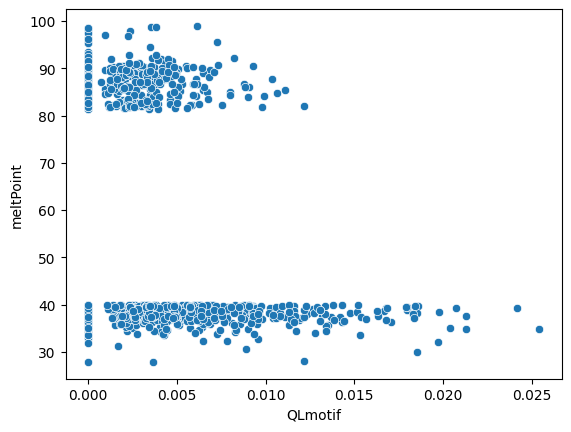

In [205]:
sns.scatterplot(data=quantiles_prokaryotes, x='QLmotif', y='meltPoint')